In [1]:
import torch
import torchvision
import sys
import matplotlib.pyplot as plt

LEARNING_RATE = 0.001
EPOCHS = 10
BATCH_SIZE = 128

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')

device: cuda


In [3]:
train_dataset = torchvision.datasets.MNIST('./', train=True, download=True)
test_dataset = torchvision.datasets.MNIST('./', train=False)

In [4]:
x_train_orig = train_dataset.train_data
y_train_orig = train_dataset.train_labels
x_test_orig = test_dataset.test_data
y_test_orig = test_dataset.test_labels

# use data with digit 0 or 1
x_train_orig = x_train_orig[(y_train_orig == 0) | (y_train_orig == 1)]
y_train_orig = y_train_orig[(y_train_orig == 0) | (y_train_orig == 1)]
x_test_orig = x_test_orig[(y_test_orig == 0) | (y_test_orig == 1)]
y_test_orig = y_test_orig[(y_test_orig == 0) | (y_test_orig == 1)]

print('x_train_orig shape: ', x_train_orig.shape)
print('y_train_orig shape: ', y_train_orig.shape)
print('x_test_orig shape: ', x_test_orig.shape)
print('y_test_orig shape: ', y_test_orig.shape)

x_train_orig shape:  torch.Size([12665, 28, 28])
y_train_orig shape:  torch.Size([12665])
x_test_orig shape:  torch.Size([2115, 28, 28])
y_test_orig shape:  torch.Size([2115])


In [5]:
x_train = (x_train_orig[:10000] / 255.).view(-1, 28 * 28).to(device=device)
y_train = y_train_orig[:10000].view(-1, 1).to(dtype=torch.float32, device=device)
x_val = (x_train_orig[10000:] / 255.).view(-1, 28 * 28).to(device=device)
y_val = y_train_orig[10000:].view(-1, 1).to(dtype=torch.float32, device=device)
x_test = (x_test_orig / 255.).view(-1, 28 * 28).to(device=device)
y_test = y_test_orig.view(-1, 1).to(dtype=torch.float32, device=device)

print('x_train shape : ', x_train.shape)
print('y_train shape : ', y_train.shape)
print('x_train shape : ', x_val.shape)
print('y_train shape : ', y_val.shape)
print('x_test  shape : ', x_test.shape)
print('y_test  shape : ', y_test.shape)

x_train shape :  torch.Size([10000, 784])
y_train shape :  torch.Size([10000, 1])
x_train shape :  torch.Size([2665, 784])
y_train shape :  torch.Size([2665, 1])
x_test  shape :  torch.Size([2115, 784])
y_test  shape :  torch.Size([2115, 1])


In [6]:
training_set = torch.utils.data.TensorDataset(x_train, y_train)
train_loader = torch.utils.data.DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True)

In [7]:
class LogisticRegressor(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = torch.nn.Linear(784, 1)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        z = self.fc(x)
        y = self.sigmoid(z)
        return y

In [8]:
model = LogisticRegressor().to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

optimizer.zero_grad()

In [9]:
for epoch in range(EPOCHS):
    total_loss = 0
    
    for xs, ys in train_loader:
        pred = model(xs)
        loss = criterion(pred, ys)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        total_loss += loss.item()
    
    with torch.no_grad():
        pred = model(x_val)
        accuracy = (pred >= 0.5).eq(y_val.data).sum() / len(x_val) * 100
        loss = criterion(pred, y_val)
    
    print(f'[Epoch: {epoch+1:>2}] Validation Loss: {loss:>.6f} Validation Accuracy: {accuracy:>.2f} %')

[Epoch:  1] Validation Loss: 0.496408 Validation Accuracy: 98.50 %
[Epoch:  2] Validation Loss: 0.387748 Validation Accuracy: 99.55 %
[Epoch:  3] Validation Loss: 0.317815 Validation Accuracy: 99.55 %
[Epoch:  4] Validation Loss: 0.268967 Validation Accuracy: 99.59 %
[Epoch:  5] Validation Loss: 0.233185 Validation Accuracy: 99.59 %
[Epoch:  6] Validation Loss: 0.205959 Validation Accuracy: 99.55 %
[Epoch:  7] Validation Loss: 0.184590 Validation Accuracy: 99.59 %
[Epoch:  8] Validation Loss: 0.167413 Validation Accuracy: 99.62 %
[Epoch:  9] Validation Loss: 0.153329 Validation Accuracy: 99.62 %
[Epoch: 10] Validation Loss: 0.141560 Validation Accuracy: 99.66 %


In [10]:
with torch.no_grad():
    y_pred = model(x_test)
    accuracy = (y_pred >= 0.5).eq(y_test.data).sum() / len(x_test) * 100
    print(f'Test Accuracy: {accuracy:>.2f} %')

Test Accuracy: 99.76 %


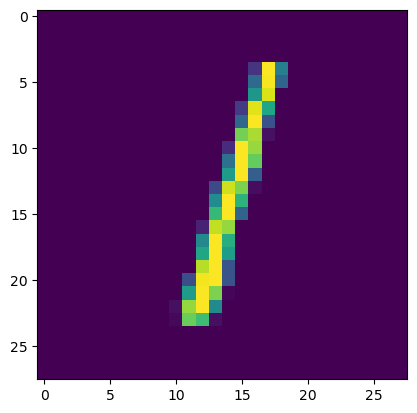

label:  1 (0.842)


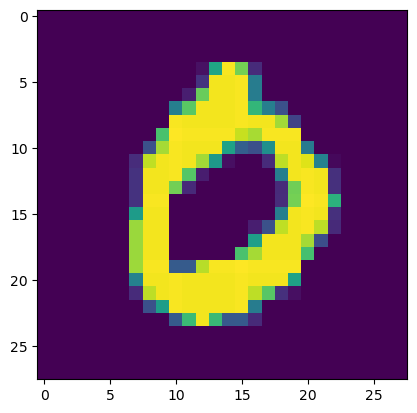

label:  0 (0.065)


In [11]:
# display result

x = x_test[0]
y = y_test[0]

y_pred = model(x).to('cpu')

plt.imshow(x.to('cpu').view(28,28))
plt.show()
print("label: ", 1 if (y_pred >= 0.5) == True else 0, f'({y_pred[0]:.3f})')

x = x_test[1]
y = y_test[1]

y_pred = model(x).to('cpu')

plt.imshow(x.to('cpu').view(28,28))
plt.show()
print("label: ", 1 if (y_pred >= 0.5) == True else 0, f'({y_pred[0]:.3f})')

In [12]:
# extract weight and bias to binary file
parameters = model.parameters()

weight = next(parameters).to('cpu').detach().numpy()
with open('weight.bin', 'wb') as f:
    f.write(weight.tobytes())

bias = next(parameters).to('cpu').detach().numpy()
with open('bias.bin', 'wb') as f:
    f.write(bias.tobytes())

In [13]:
x = x_test[0].to('cpu').detach().numpy()
with open('1.bin', 'wb') as f:
    f.write(x.tobytes())

x = x_test[1].to('cpu').detach().numpy()
with open('0.bin', 'wb') as f:
    f.write(x.tobytes())